# Classification

## Get Data - MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

f:\AI_again\classification\venv\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
print(X.shape, y.shape)

(70000, 784) (70000,)


### Visualize a sample

In [5]:
import matplotlib.pyplot as plt
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

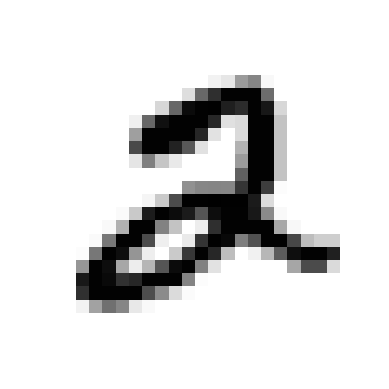

In [6]:
sample = X[5]
plot_digit(sample)
plt.show()

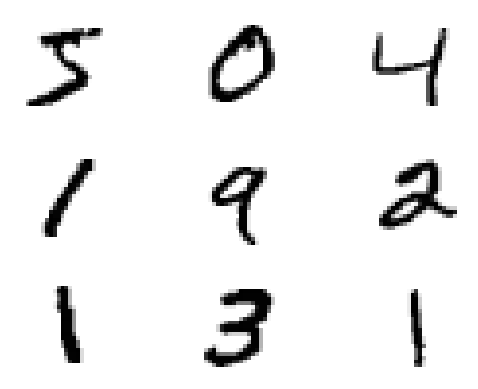

In [7]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plot_digit(X[i])

plt.show()

### Split trainset and testset
The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

## Training a Binary Classifier
Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5.

In [9]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([X[0]])

array([ True])

## Performance Measures

### Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

That’s right, it has over 90% accuracy! This is simply because only about
10% of the images are 5s, so if you always guess that an image is not a 5, you
will be right about 90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance
measure for classifiers, especially when you are dealing with ***skewed datasets***
(i.e., when some classes are much more frequent than others). A much better
way to evaluate the performance of a classifier is to look at the confusion
matrix (CM).

### Confusion Matrices
To compute the confusion matrix, you first need to have a set of predictions
so that they can be compared to the actual targets. 

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs k-fold
cross-validation, but instead of returning the evaluation scores, it returns the
predictions made on each test fold. This means that you get a clean prediction
for each instance in the training set.

In [14]:
from sklearn.metrics import  confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column
represents a predicted class. The first row of this matrix considers non-5
images (the **negative class**): 53,892 of them were correctly classified as non-
5s (they are called ***true negatives***), while the remaining 687 were wrongly
classified as 5s (***false positives***, also called type I errors). The second row
considers the images of 5s (the **positive class**): 1,891 were wrongly classified
as non-5s (***false negatives***, also called type II errors), while the remaining
3,530 were correctly classified as 5s (***true positives***).
> **|TN FP|** <br>
> **|FN TP|**

### Precision and Recall
The confusion matrix gives you a lot of information, but sometimes you may
prefer a more concise metric. An interesting one to look at is the accuracy of
the positive predictions; this is called the **precision** of the classifier. <br>
***precision = TP / (TP+FP)*** <br>
Precision is typically used along with another metric named
recall, also called sensitivity or the true positive rate (TPR): this is the ratio
of positive instances that are correctly detected by the classifier. <br>
***recall = TP / (TP + FN)***

In [15]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

0.8370879772350012 0.6511713705958311


It is often convenient to combine precision and recall into a single metric
called the F score, especially when you need a single metric to compare two
classifiers. The F score is the harmonic mean of precision and recall. <br>
F1 = 2*(1/precision + 1/recall) = 2*(precision * recall)/(precision + recall)

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### The Precision/Recall Trade-off
For each instance, it computes a score based on a
decision function. If that score is greater than a threshold.
Scikit-Learn does not let you set the threshold directly, but it does give you
access to the decision scores that it uses to make predictions. Instead of
calling the classifier’s predict() method, you can call its decision_function()
method, which returns a score for each instance, and then use any threshold
you want to make predictions based on those scores.

In [18]:
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

How do you decide which threshold to use? First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time
specify that you want to return decision scores instead of predictions:

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute
precision and recall for all possible thresholds (the function adds a last
precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


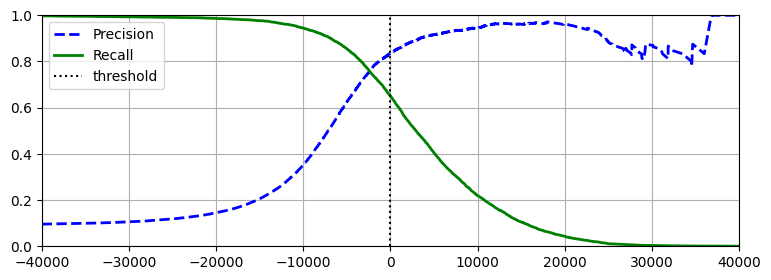

In [31]:
plt.figure(figsize=(9,3))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend()
plt.grid()
plt.axis([-40000,40000,0,1])
plt.show()


In [32]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]

### The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool
used with binary classifiers. It is very similar to the precision/recall curve, but
instead of plotting precision versus recall, the ROC curve plots the true
positive rate (another name for recall) against the false positive rate (FPR).
The FPR (also called the fall-out) is the ratio of negative instances that are
incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as
negative. The TNR is also called specificity. Hence, the ROC curve plots
sensitivity (recall) versus 1 – specificity. <br>
To plot the ROC curve, you first use the roc_curve() function to compute the
TPR and FPR for various threshold values:


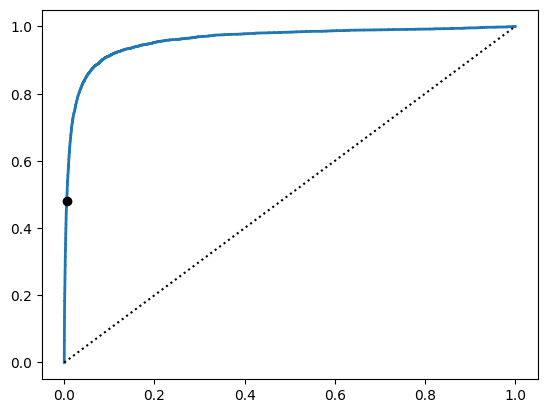

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
[...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Now, we create a RandomForestClassifier, which can compare with SGDClassifier in terms of PR curve and F1 Score

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

The precision_recall_curve() function expects labels and scores for each
instance, so we need to train the random forest classifier and make it assign a
score to each instance. But the RandomForestClassifier class does not have a
decision_function() method, due to the way it works. Luckily, it has a predict_proba() method that returns class
probabilities for each instance, and we can just use the probability of the
positive class as a score, so it will work fine.

In [37]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

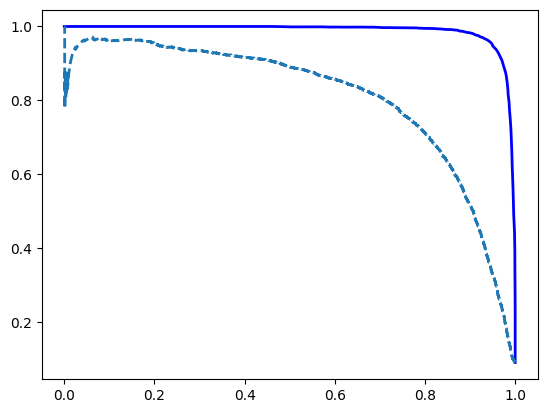

In [38]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
y_train_5, y_scores_forest)

# Plot
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

You now know how to train binary classifiers, choose the appropriate metric
1
for your task, evaluate your classifiers using cross-validation, select the
precision/recall trade-off that fits your needs, and use several metrics and
curves to compare various models. You’re ready to try to detect more than
just the 5s.